# Feature Analysis: Demographics Variables

## Purpose
This notebook performs comprehensive feature analysis on the demographics variables (ACS + engineered features) to identify:
1. **Redundant features** - highly correlated pairs (|r| > 0.85)
2. **Multicollinearity** - VIF values indicating collinear variables
3. **Predictive relevance** - correlation with target variable (CVD Mortality Rate)
4. **Feature groupings** - hierarchical clustering patterns

## Goal
Make informed decisions about which features to keep/drop before modeling:
- **Drop** one variable from highly correlated pairs
- **Keep** the variable with stronger target correlation and lower VIF

## Scope
This notebook analyzes **demographics variables only** (~21 features):
- Original ACS variables (13)
- Engineered percentage features (6)
- Population counts (2)

Weather variables will be analyzed separately in the next notebook.

## Output
- Visualizations saved to: `data_cvd/outputs/feature_analysis/`
- Publication-ready plots (high DPI, proper sizing)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for publication quality
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Print versions for reproducibility
print("Library versions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  matplotlib: {plt.matplotlib.__version__}")
print(f"  seaborn: {sns.__version__}")

Library versions:
  pandas: 2.3.3
  numpy: 1.26.4
  matplotlib: 3.10.8
  seaborn: 0.13.2


## 2. Setup Output Directory

Create directory for saving all visualizations.

In [2]:
# Create output directory for plots
output_dir = Path('../data_cvd/outputs/feature_analysis')
output_dir.mkdir(parents=True, exist_ok=True)

print(f" Output directory created: {output_dir}")
print(f"  All plots will be saved here in high resolution (300 DPI)")

 Output directory created: ../data_cvd/outputs/feature_analysis
  All plots will be saved here in high resolution (300 DPI)


## 3. Load Data

Load the combined dataset from notebook 05.

In [3]:
# Load final combined dataset
df = pd.read_csv('../data_cvd/combined_final/final_combined_all_variables.csv')

print("=" * 70)
print("DATASET LOADED")
print("=" * 70)
print(f"Shape: {df.shape}")
print(f"  - Rows: {df.shape[0]:,}")
print(f"  - Columns: {df.shape[1]}")
print(f"  - Years: {sorted(df['Year'].unique())}")

DATASET LOADED
Shape: (24487, 132)
  - Rows: 24,487
  - Columns: 132
  - Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


## 4. Identify Demographics Variables

Extract only the demographics/ACS variables for analysis.

In [4]:
# Define demographics variables (ACS + engineered features)
# Exclude: identifiers (County, State, Year, fips), target (CVD Mortality Rate), 
# livestock variables, and weather variables

# Expected demographics columns
demographics_cols = [
    # Original ACS variables
    'Median Household Income',
    'Total Population',
    'Gini Index',
    'Median Age',
    'Poverty Rate',
    'Unemployment Rate',
    'Disability Rate',
    "Bachelor's Degree or Higher (%)",
    "High School Degree or Higher (%)",
    # Engineered percentage features
    'White Population (%)',
    'Hispanic Population (%)',
    'Black Population (%)',
    'Households with No Vehicle (%)',
    'Rent Burden (+50% of HI)',
    'Single Mother Families (%)'
]

# Filter to only demographics columns that exist in the dataset
demographics_cols = [col for col in demographics_cols if col in df.columns]

# Extract demographics subset
demographics_df = df[demographics_cols + ['CVD Mortality Rate']].copy()

print("Demographics variables identified:")
print(f"  Total: {len(demographics_cols)} features")
print("\nVariables:")
for i, col in enumerate(demographics_cols, 1):
    print(f"  {i:2}. {col}")

print(f"\n+ Target variable: CVD Mortality Rate")
print(f"\nSubset shape: {demographics_df.shape}")

Demographics variables identified:
  Total: 15 features

Variables:
   1. Median Household Income
   2. Total Population
   3. Gini Index
   4. Median Age
   5. Poverty Rate
   6. Unemployment Rate
   7. Disability Rate
   8. Bachelor's Degree or Higher (%)
   9. High School Degree or Higher (%)
  10. White Population (%)
  11. Hispanic Population (%)
  12. Black Population (%)
  13. Households with No Vehicle (%)
  14. Rent Burden (+50% of HI)
  15. Single Mother Families (%)

+ Target variable: CVD Mortality Rate

Subset shape: (24487, 16)


## 5. Descriptive Statistics

Overview of demographics variables: distributions, ranges, missing values.

In [5]:
print("=" * 70)
print("DESCRIPTIVE STATISTICS")
print("=" * 70)

# Check for missing values
missing = demographics_df.isnull().sum()
if missing.sum() > 0:
    print("\n Missing values detected:")
    for col in missing[missing > 0].index:
        print(f"  {col}: {missing[col]:,} ({missing[col]/len(demographics_df)*100:.2f}%)")
else:
    print("\n No missing values")

# Summary statistics
print("\nSummary statistics:")
demographics_df.describe()

DESCRIPTIVE STATISTICS

 No missing values

Summary statistics:


,Median Household Income,Total Population,Gini Index,Median Age,Poverty Rate,Unemployment Rate,Disability Rate,Bachelor's Degree or Higher (%),High School Degree or Higher (%),White Population (%),Hispanic Population (%),Black Population (%),Households with No Vehicle (%),Rent Burden (+50% of HI),Single Mother Families (%),CVD Mortality Rate
count,24487.000000,2.448700e+04,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000
mean,48233.304651,1.026567e+05,0.442419,40.916838,16.261861,7.336080,15.754952,20.333132,85.025659,83.777410,8.850831,9.159245,6.335325,18.749546,9.333859,0.002709
std,12781.930179,3.268580e+05,0.034952,5.192459,6.467213,3.554617,4.393675,9.295640,7.034022,16.170373,13.539941,14.603102,3.600459,6.295253,3.569848,0.000549
min,18972.000000,6.120000e+02,0.320900,21.900000,2.300000,0.000000,3.700000,2.800000,45.200000,8.327612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000731
25%,39884.500000,1.161500e+04,0.418400,37.800000,11.600000,4.900000,12.600000,13.900000,80.800000,77.444854,1.902210,0.629889,4.353163,14.689051,6.990433,0.002310
50%,46443.000000,2.652800e+04,0.440100,40.900000,15.400000,6.900000,15.300000,18.100000,86.500000,90.125538,3.724928,2.280021,5.781473,18.861210,8.876812,0.002653
75%,54041.500000,6.877650e+04,0.463900,44.000000,19.800000,9.300000,18.400000,24.300000,90.300000,95.425543,8.972632,10.492625,7.593302,22.869515,11.127111,0.003059
max,142299.000000,1.010572e+07,0.707000,67.400000,55.500000,29.900000,36.900000,75.300000,98.700000,100.000000,99.184800,87.412281,78.304029,50.156703,30.714648,0.006389


## 6. Inter-Feature Correlation Analysis

### 6.1 Correlation Matrix Heatmap

Visualize correlations between all demographics variables.

 Saved: demographics_correlation_matrix.png


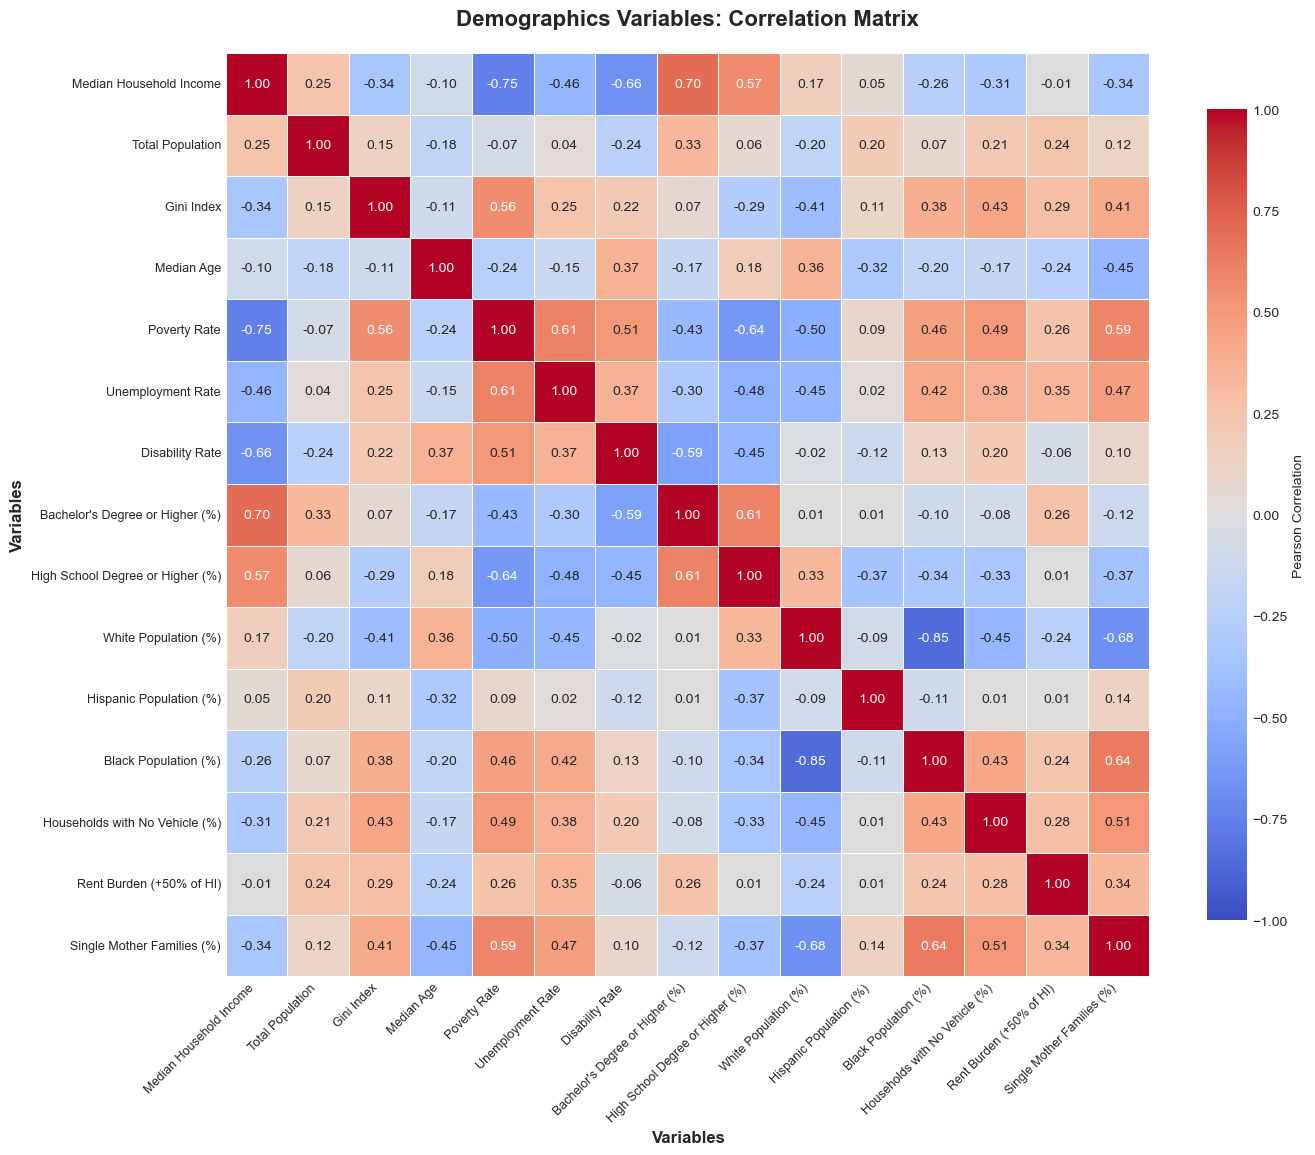

In [6]:
# Calculate correlation matrix (exclude target variable for now)
corr_matrix = demographics_df[demographics_cols].corr()

# Create publication-quality heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Create heatmap with annotations
sns.heatmap(corr_matrix, 
            annot=True,  # Show correlation values
            fmt='.2f',   # Two decimal places
            cmap='coolwarm',  # Diverging colormap
            center=0,    # Center colormap at 0
            vmin=-1, vmax=1,  # Fix scale
            square=True,  # Square cells
            linewidths=0.5,  # Grid lines
            cbar_kws={'label': 'Pearson Correlation', 'shrink': 0.8},
            ax=ax)

plt.title('Demographics Variables: Correlation Matrix', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Variables', fontsize=12, fontweight='bold')
plt.ylabel('Variables', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'demographics_correlation_matrix.png', 
            dpi=300, bbox_inches='tight')
print(" Saved: demographics_correlation_matrix.png")
plt.show()

### 6.2 High Correlation Pairs

Identify variable pairs with |correlation| > 0.85 (indicating potential redundancy).

In [7]:
print("=" * 70)
print("HIGH CORRELATION PAIRS (|r| > 0.85)")
print("=" * 70)

# Find high correlation pairs
threshold = 0.85
high_corr_pairs = []

# Iterate through correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    print(f"\nFound {len(high_corr_df)} pairs with |correlation| > {threshold}:")
    print("\n" + high_corr_df.to_string(index=False))
    
    # Save to CSV
    high_corr_df.to_csv(output_dir / 'high_correlation_pairs.csv', index=False)
    print(f"\n Saved: high_correlation_pairs.csv")
else:
    print(f"\n No variable pairs with |correlation| > {threshold}")

HIGH CORRELATION PAIRS (|r| > 0.85)

Found 1 pairs with |correlation| > 0.85:

          Variable 1           Variable 2  Correlation
White Population (%) Black Population (%)    -0.852227

 Saved: high_correlation_pairs.csv


### 6.3 Hierarchical Clustering Dendrogram

Visualize natural groupings of correlated variables using hierarchical clustering.

 Saved: demographics_dendrogram.png


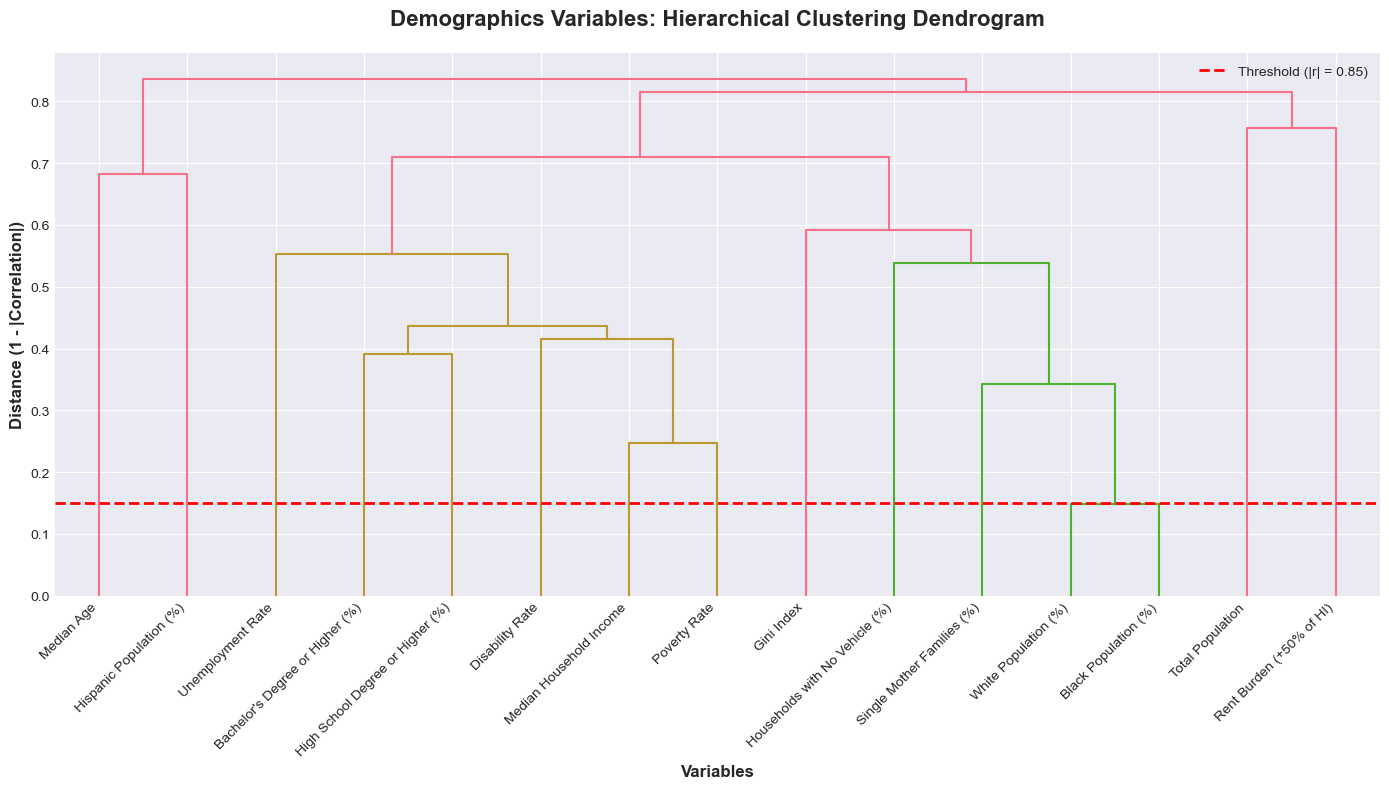


Interpretation:
  - Variables connected below the red line (threshold) are highly correlated
  - Consider keeping only one representative from each tight cluster


In [8]:
# Calculate distance matrix from correlations
# Distance = 1 - |correlation|
distance_matrix = 1 - np.abs(corr_matrix)

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Create publication-quality dendrogram
fig, ax = plt.subplots(figsize=(14, 8))

dendrogram(linkage_matrix, 
           labels=corr_matrix.columns,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=False,
           leaf_font_size=10,
           ax=ax)

plt.title('Demographics Variables: Hierarchical Clustering Dendrogram', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Variables', fontsize=12, fontweight='bold')
plt.ylabel('Distance (1 - |Correlation|)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add horizontal line at threshold
threshold_distance = 1 - threshold
plt.axhline(y=threshold_distance, color='r', linestyle='--', 
            linewidth=2, label=f'Threshold (|r| = {threshold})')
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'demographics_dendrogram.png', 
            dpi=300, bbox_inches='tight')
print(" Saved: demographics_dendrogram.png")
plt.show()

print("\nInterpretation:")
print("  - Variables connected below the red line (threshold) are highly correlated")
print("  - Consider keeping only one representative from each tight cluster")

## 7. Relationship with Target Variable

### 7.1 Feature-Target Correlation

Calculate correlation of each feature with CVD Mortality Rate.

FEATURE CORRELATION WITH TARGET (CVD Mortality Rate)

Ranked by absolute correlation:

Bachelor's Degree or Higher (%)    -0.549643
Median Household Income            -0.543574
Poverty Rate                        0.542856
High School Degree or Higher (%)   -0.519137
Disability Rate                     0.517253
Single Mother Families (%)          0.395995
Unemployment Rate                   0.394920
Black Population (%)                0.377198
White Population (%)               -0.283695
Households with No Vehicle (%)      0.262730
Gini Index                          0.232995
Hispanic Population (%)            -0.148300
Total Population                   -0.143202
Median Age                         -0.134691
Rent Burden (+50% of HI)            0.016941

 Saved: target_correlation_barplot.png


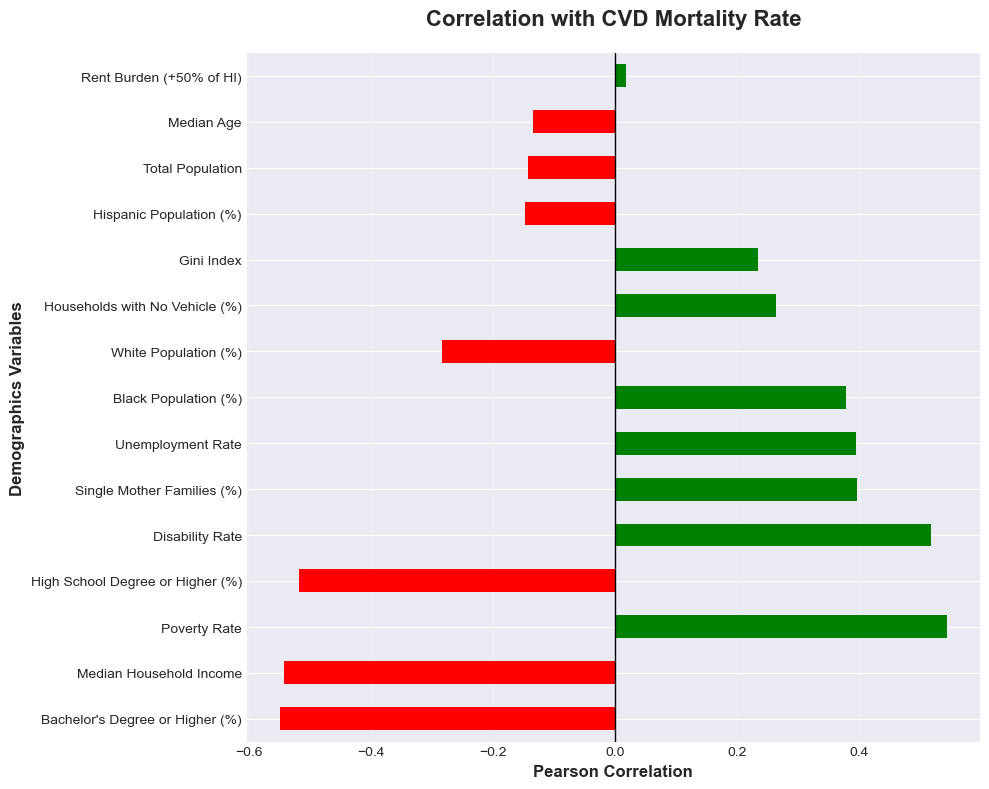

 Saved: target_correlations.csv


In [9]:
# Calculate correlation with target variable
target_corr = demographics_df[demographics_cols].corrwith(demographics_df['CVD Mortality Rate'])
target_corr = target_corr.sort_values(key=abs, ascending=False)

print("=" * 70)
print("FEATURE CORRELATION WITH TARGET (CVD Mortality Rate)")
print("=" * 70)
print("\nRanked by absolute correlation:")
print("\n" + target_corr.to_string())

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in target_corr.values]
target_corr.plot(kind='barh', color=colors, ax=ax)

plt.title('Correlation with CVD Mortality Rate', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Pearson Correlation', fontsize=12, fontweight='bold')
plt.ylabel('Demographics Variables', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'target_correlation_barplot.png', 
            dpi=300, bbox_inches='tight')
print("\n Saved: target_correlation_barplot.png")
plt.show()

# Save to CSV
target_corr_df = pd.DataFrame({
    'Variable': target_corr.index,
    'Correlation with Target': target_corr.values
})
target_corr_df.to_csv(output_dir / 'target_correlations.csv', index=False)
print(" Saved: target_correlations.csv")

### 7.2 Bivariate Scatter Plots

Visualize relationships between top correlated features and target variable.

 Saved: top_features_scatter_plots.png


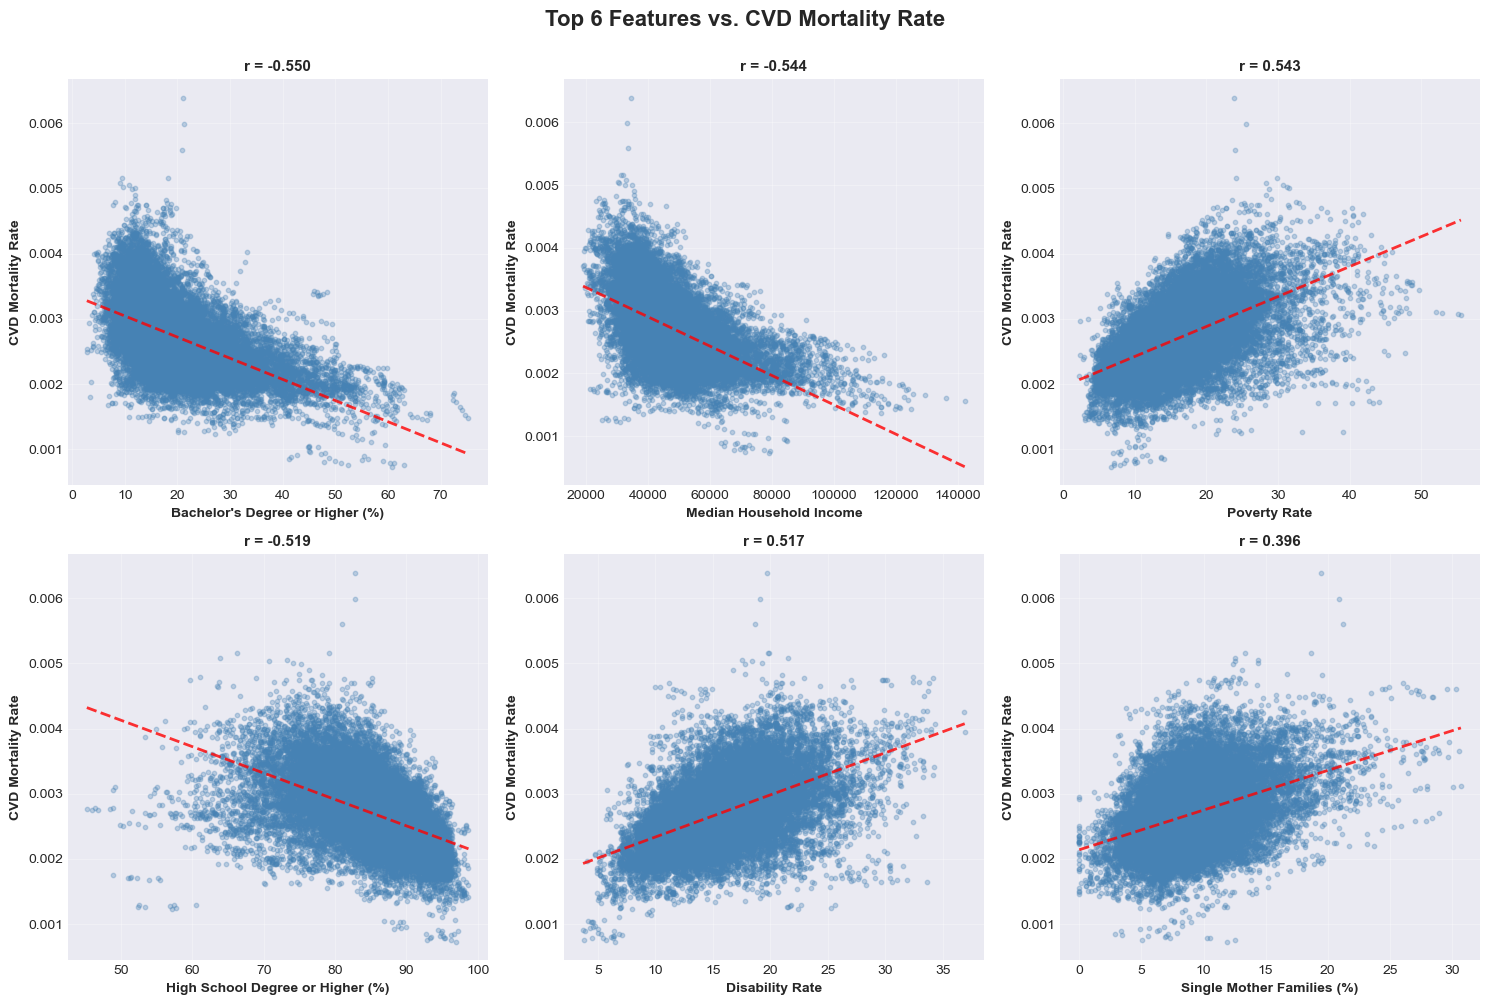

In [10]:
# Select top 6 features by absolute correlation
top_features = target_corr.abs().nlargest(6).index.tolist()

# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Scatter plot with regression line
    ax.scatter(demographics_df[feature], 
               demographics_df['CVD Mortality Rate'],
               alpha=0.3, s=10, color='steelblue')
    
    # Add regression line
    z = np.polyfit(demographics_df[feature].dropna(), 
                   demographics_df.loc[demographics_df[feature].notna(), 'CVD Mortality Rate'],
                   1)
    p = np.poly1d(z)
    ax.plot(demographics_df[feature].sort_values(), 
            p(demographics_df[feature].sort_values()),
            "r--", linewidth=2, alpha=0.8)
    
    # Labels and correlation
    corr_val = target_corr[feature]
    ax.set_xlabel(feature, fontsize=10, fontweight='bold')
    ax.set_ylabel('CVD Mortality Rate', fontsize=10, fontweight='bold')
    ax.set_title(f'r = {corr_val:.3f}', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)

plt.suptitle('Top 6 Features vs. CVD Mortality Rate', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'top_features_scatter_plots.png', 
            dpi=300, bbox_inches='tight')
print(" Saved: top_features_scatter_plots.png")
plt.show()

## 8. Multicollinearity Detection (VIF)

Calculate Variance Inflation Factor (VIF) for each variable.
- **VIF < 5**: Low multicollinearity
- **VIF 5-10**: Moderate multicollinearity
- **VIF > 10**: High multicollinearity (problematic)

In [11]:
# Prepare data for VIF calculation (remove any NaN values)
vif_data = demographics_df[demographics_cols].dropna()

print("=" * 70)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("=" * 70)
print("\nCalculating VIF for each variable...")
print("(This may take a minute for 15+ variables)\n")

# Calculate VIF for each feature
vif_results = []
for i, col in enumerate(demographics_cols):
    try:
        vif_value = variance_inflation_factor(vif_data.values, i)
        vif_results.append({
            'Variable': col,
            'VIF': vif_value
        })
        print(f"  ✓ {col}: VIF = {vif_value:.2f}")
    except Exception as e:
        print(f"  ✗ {col}: Error calculating VIF ({str(e)})")
        vif_results.append({
            'Variable': col,
            'VIF': np.nan
        })

# Create VIF dataframe
vif_df = pd.DataFrame(vif_results)
vif_df = vif_df.sort_values('VIF', ascending=False)

print("\n" + "=" * 70)
print("VIF RESULTS (sorted by VIF value):")
print("=" * 70)
print("\n" + vif_df.to_string(index=False))

# Interpretation
high_vif = vif_df[vif_df['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n {len(high_vif)} variables with VIF > 10 (high multicollinearity):")
    for _, row in high_vif.iterrows():
        print(f"  - {row['Variable']}: VIF = {row['VIF']:.2f}")
else:
    print("\n No variables with VIF > 10")

# Save to CSV
vif_df.to_csv(output_dir / 'vif_analysis.csv', index=False)
print("\n Saved: vif_analysis.csv")

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

Calculating VIF for each variable...
(This may take a minute for 15+ variables)

  ✓ Median Household Income: VIF = 53.26
  ✓ Total Population: VIF = 1.48
  ✓ Gini Index: VIF = 272.13
  ✓ Median Age: VIF = 129.40
  ✓ Poverty Rate: VIF = 38.20
  ✓ Unemployment Rate: VIF = 10.12
  ✓ Disability Rate: VIF = 36.01
  ✓ Bachelor's Degree or Higher (%): VIF = 17.56
  ✓ High School Degree or Higher (%): VIF = 278.78
  ✓ White Population (%): VIF = 115.41
  ✓ Hispanic Population (%): VIF = 2.15
  ✓ Black Population (%): VIF = 5.98
  ✓ Households with No Vehicle (%): VIF = 6.79
  ✓ Rent Burden (+50% of HI): VIF = 15.21
  ✓ Single Mother Families (%): VIF = 21.89

VIF RESULTS (sorted by VIF value):

                        Variable        VIF
High School Degree or Higher (%) 278.780860
                      Gini Index 272.130601
                      Median Age 129.400590
            White Population (%) 115.409539
         Median Household Income  53.2595

 Saved: vif_barplot.png


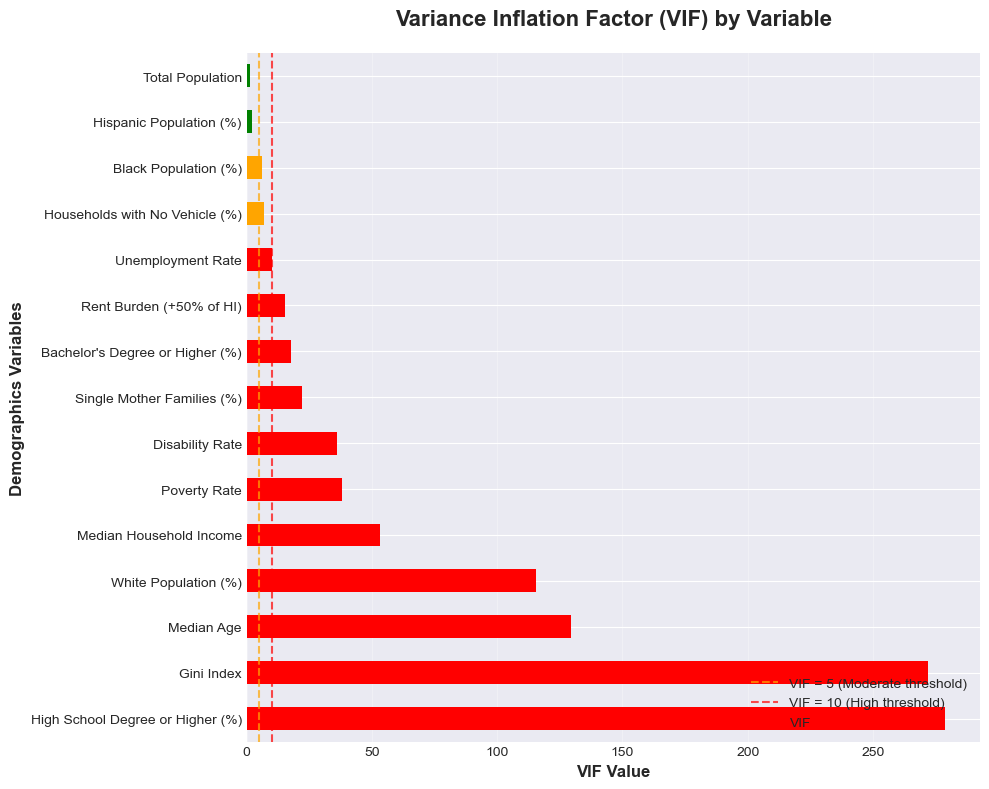

In [12]:
# Visualize VIF values
fig, ax = plt.subplots(figsize=(10, 8))

# Color code by severity
colors = ['green' if x < 5 else 'orange' if x < 10 else 'red' 
          for x in vif_df['VIF'].values]

vif_df.set_index('Variable')['VIF'].plot(kind='barh', color=colors, ax=ax)

plt.title('Variance Inflation Factor (VIF) by Variable', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('VIF Value', fontsize=12, fontweight='bold')
plt.ylabel('Demographics Variables', fontsize=12, fontweight='bold')

# Add reference lines
plt.axvline(x=5, color='orange', linestyle='--', linewidth=1.5, 
            alpha=0.7, label='VIF = 5 (Moderate threshold)')
plt.axvline(x=10, color='red', linestyle='--', linewidth=1.5, 
            alpha=0.7, label='VIF = 10 (High threshold)')

plt.legend(loc='lower right', fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'vif_barplot.png', 
            dpi=300, bbox_inches='tight')
print(" Saved: vif_barplot.png")
plt.show()

## 9. Decision Framework

### 9.1 Combine All Metrics

Create comprehensive table with all relevant metrics for decision-making.

In [13]:
# Combine all metrics into one dataframe
decision_df = pd.DataFrame({
    'Variable': demographics_cols,
    'Target_Correlation': [target_corr[col] for col in demographics_cols],
    'Abs_Target_Correlation': [abs(target_corr[col]) for col in demographics_cols],
    'VIF': [vif_df[vif_df['Variable'] == col]['VIF'].values[0] if col in vif_df['Variable'].values else np.nan 
            for col in demographics_cols]
})

# Sort by absolute target correlation (descending)
decision_df = decision_df.sort_values('Abs_Target_Correlation', ascending=False)

print("=" * 70)
print("COMPREHENSIVE DECISION METRICS")
print("=" * 70)
print("\n" + decision_df.to_string(index=False))

# Save to CSV
decision_df.to_csv(output_dir / 'feature_decision_metrics.csv', index=False)
print("\n Saved: feature_decision_metrics.csv")

COMPREHENSIVE DECISION METRICS

                        Variable  Target_Correlation  Abs_Target_Correlation        VIF
 Bachelor's Degree or Higher (%)           -0.549643                0.549643  17.564820
         Median Household Income           -0.543574                0.543574  53.259543
                    Poverty Rate            0.542856                0.542856  38.203266
High School Degree or Higher (%)           -0.519137                0.519137 278.780860
                 Disability Rate            0.517253                0.517253  36.006847
      Single Mother Families (%)            0.395995                0.395995  21.887670
               Unemployment Rate            0.394920                0.394920  10.117227
            Black Population (%)            0.377198                0.377198   5.977964
            White Population (%)           -0.283695                0.283695 115.409539
  Households with No Vehicle (%)            0.262730                0.262730   6.787483


### 9.2 Decision Guidelines

For each highly correlated pair (|r| > 0.85), apply the following decision rules:

**Decision Criteria:**
1. **Target Correlation**: Keep variable with higher |correlation| with CVD Mortality Rate
2. **VIF**: Prefer variable with lower VIF (less multicollinearity)
3. **Interpretability**: If metrics are similar, keep more interpretable variable

**Actions:**
- Document which variable to **KEEP** and which to **DROP**
- Provide clear reasoning for each decision

In [14]:
print("=" * 70)
print("FEATURE SELECTION RECOMMENDATIONS")
print("=" * 70)

if 'high_corr_df' in locals() and len(high_corr_df) > 0:
    print(f"\nAnalyzing {len(high_corr_df)} highly correlated pairs...\n")
    
    recommendations = []
    
    for idx, row in high_corr_df.iterrows():
        var1 = row['Variable 1']
        var2 = row['Variable 2']
        corr = row['Correlation']
        
        # Get metrics for both variables
        var1_metrics = decision_df[decision_df['Variable'] == var1].iloc[0]
        var2_metrics = decision_df[decision_df['Variable'] == var2].iloc[0]
        
        print(f"Pair {idx+1}: {var1} vs {var2}")
        print(f"  Inter-correlation: {corr:.3f}")
        print(f"\n  {var1}:")
        print(f"    - Target correlation: {var1_metrics['Target_Correlation']:.3f}")
        print(f"    - VIF: {var1_metrics['VIF']:.2f}")
        print(f"\n  {var2}:")
        print(f"    - Target correlation: {var2_metrics['Target_Correlation']:.3f}")
        print(f"    - VIF: {var2_metrics['VIF']:.2f}")
        
        # Decision logic
        var1_score = var1_metrics['Abs_Target_Correlation'] - (var1_metrics['VIF'] / 100)
        var2_score = var2_metrics['Abs_Target_Correlation'] - (var2_metrics['VIF'] / 100)
        
        if var1_score > var2_score:
            keep, drop = var1, var2
            reason = f"Higher target correlation ({var1_metrics['Abs_Target_Correlation']:.3f} vs {var2_metrics['Abs_Target_Correlation']:.3f})"
        else:
            keep, drop = var2, var1
            reason = f"Higher target correlation ({var2_metrics['Abs_Target_Correlation']:.3f} vs {var1_metrics['Abs_Target_Correlation']:.3f})"
        
        print(f"\n  → RECOMMENDATION: KEEP '{keep}', DROP '{drop}'")
        print(f"    Reason: {reason}")
        print("\n" + "-" * 70 + "\n")
        
        recommendations.append({
            'Correlated Pair': f"{var1} <-> {var2}",
            'Correlation': corr,
            'Keep': keep,
            'Drop': drop,
            'Reason': reason
        })
    
    # Save recommendations
    recommendations_df = pd.DataFrame(recommendations)
    recommendations_df.to_csv(output_dir / 'feature_selection_recommendations.csv', index=False)
    print(" Saved: feature_selection_recommendations.csv")
    
else:
    print("\n No highly correlated pairs detected.")
    print("  All demographics features can be retained.")

FEATURE SELECTION RECOMMENDATIONS

Analyzing 1 highly correlated pairs...

Pair 1: White Population (%) vs Black Population (%)
  Inter-correlation: -0.852

  White Population (%):
    - Target correlation: -0.284
    - VIF: 115.41

  Black Population (%):
    - Target correlation: 0.377
    - VIF: 5.98

  → RECOMMENDATION: KEEP 'Black Population (%)', DROP 'White Population (%)'
    Reason: Higher target correlation (0.377 vs 0.284)

----------------------------------------------------------------------

 Saved: feature_selection_recommendations.csv


## 10. Summary

**Analysis Completed:**
-  Descriptive statistics
-  Inter-feature correlation matrix (heatmap)
-  High correlation pairs identification (|r| > 0.85)
-  Hierarchical clustering (dendrogram)
-  Feature-target correlations
-  Bivariate scatter plots (top 6 features)
-  Multicollinearity detection (VIF)
-  Decision recommendations

**Output Files:**
All visualizations and tables saved to: `data_cvd/outputs/feature_analysis/`

**Next Steps:**
1. Review recommendations and make final decisions
2. Proceed to weather variables analysis (next notebook)
3. Drop selected features from combined dataset
4. Begin machine learning modeling

In [15]:
# List all generated files
print("=" * 70)
print("OUTPUT FILES GENERATED")
print("=" * 70)
print(f"\nDirectory: {output_dir}\n")

output_files = sorted(output_dir.glob('*'))
for file in output_files:
    size_kb = file.stat().st_size / 1024
    print(f"   {file.name} ({size_kb:.1f} KB)")

print(f"\nTotal files: {len(output_files)}")

OUTPUT FILES GENERATED

Directory: ../data_cvd/outputs/feature_analysis

   demographics_correlation_matrix.png (920.7 KB)
   demographics_dendrogram.png (350.8 KB)
   feature_decision_metrics.csv (1.2 KB)
   feature_selection_recommendations.csv (0.2 KB)
   high_correlation_pairs.csv (0.1 KB)
   target_correlation_barplot.png (206.1 KB)
   target_correlations.csv (0.6 KB)
   top_features_scatter_plots.png (2661.3 KB)
   vif_analysis.csv (0.6 KB)
   vif_barplot.png (229.6 KB)

Total files: 10
